In [1]:
#Common tasks libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Miscellaeneous libraries.
import re
from datetime import timedelta
from joblib import dump, load

#Common tasks sklearn libraries.
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Modle libraries sklearn.
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

#Ignore convergence warnings.
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#Ignore warnings if the previous one fails.
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Separte date variables in others.
def add_datepart(df, fldname, drop=True,errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_quarter_end', 'Is_quarter_start']
    for n in attr:
        if n == 'Week':
            df[targ_pre + n] = [ts.isocalendar().week for ts in fld]
        else:
            df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

In [3]:
#We are going to classify the holidays according if they are national or regional, there are some of them that are bridged.
#So we are going to suppose that the bridge date is going to be 4 or friday.
def adjust_holidays(prevdf,daycol,boolcol):
    df = prevdf[prevdf[boolcol] == True]
    lst = []
    for i,dfiter in enumerate(df[daycol]):
        dayweek = dfiter.dayofweek
        dateNum = 4 - dayweek
        newDate = []
        newDate = [pd.Timestamp(dfiter.to_pydatetime() + timedelta(days=dateNum))]
        for item in df[[j for j in df.columns if j not in (daycol,boolcol)]].iloc[i].values:
            newDate.append(item)
        newDate.append(False)
        lst.append(newDate)
    newdf = prevdf[prevdf[boolcol] == False]
    newdf.reset_index(inplace = True, drop = True)
    newreg = pd.DataFrame(lst,columns = df.columns)
    return pd.concat(objs = (newdf,newreg))

holidays_df = pd.read_csv('./data/holidays_events.csv', parse_dates = ['date'])
mask_holidays = holidays_df['date'].dt.year != 2012
holidays_df_new = holidays_df[mask_holidays]
holidays_df_new.reset_index(inplace = True, drop = True)
holidays_df_new = adjust_holidays(holidays_df_new,'date','transferred')
holidays_df_new

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
3,2013-02-11,Holiday,National,Ecuador,Carnaval,False
4,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
6,2017-04-14,Holiday,Local,Cuenca,Fundacion de Cuenca,False
7,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha,False
8,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia,False
9,2017-09-29,Holiday,Local,Ibarra,Fundacion de Ibarra,False


In [4]:
#Loading oil data to be used.
oil_prices_df = pd.read_csv('./data/oil.csv')
oil_prices_df = oil_prices_df.dropna()
print(oil_prices_df.shape)
add_datepart(oil_prices_df,'date',False)
oil_prices_df.head()

(1175, 2)


,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
1,2013-01-02,93.14,2013,1,1,2,2,2,False,False
2,2013-01-03,92.97,2013,1,1,3,3,3,False,False
3,2013-01-04,93.12,2013,1,1,4,4,4,False,False
4,2013-01-07,93.20,2013,1,2,7,0,7,False,False
5,2013-01-08,93.21,2013,1,2,8,1,8,False,False


In [5]:
#Loading data of stores.
stores_df = pd.read_csv('./data/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
# Join with holidays.
def holidays_on_dataset(df, dfhol, dfcols, dfholcols, dfcolsfinal):
    #values
    dfcols1, dfcols2, dfcols3 = dfcols
    dfholcols1, dfholcols2, dfholval = dfholcols
    
    #local holidays
    local_holidays = pd.merge(left = df, right = dfhol, how = 'inner', 
                             right_on = dfholcols1, left_on = dfcols1)
    local_holidays['is_holiday_local'] = 1
    dfcolsfinal.append('is_holiday_local')
    
    #national holidays
    national_holidays = pd.merge(left = df[[dfcols2]], right = dfhol, how = 'inner', on = dfcols2)
    national_holidays = national_holidays[national_holidays[dfholcols2] == dfholval].reset_index(drop = True)
    national_holidays['is_holiday_national'] = 1
    dfcolsfinal.append('is_holiday_national')
    
    #holidays
    local_national_holidays = pd.concat(objs = (local_holidays, national_holidays)).reset_index(drop = True)
    local_national_holidays = local_national_holidays[dfcols3]
    
    #Fill nulls
    lstvals = [dfholval,0,0]
    for elem,name in enumerate(local_national_holidays.columns[1:]):
        local_national_holidays[name] = local_national_holidays[name].fillna(lstvals[elem])
    
    #new holidays df
    local_national_holidays.drop_duplicates(inplace = True)
    local_national_holidays.sort_values(by = dfcols2, inplace = True)
    local_national_holidays.reset_index(inplace = True, drop = True)
    
    #Join to df
    new_df = pd.merge(left = df, right = local_national_holidays, how = 'left', on = dfcols2)
    
    #grab by columns
    new_df = new_df[dfcolsfinal]
    new_df['is_holiday_local'] = new_df['is_holiday_local'].fillna(0)
    new_df['is_holiday_national'] = new_df['is_holiday_national'].fillna(0)
    
    #Return the df now refactorized
    return new_df

In [7]:
#Make one hot encoding on a column.
def one_hot_encoding(df,col):
    onehot = OneHotEncoder()
    new_cols = onehot.fit_transform(df[[col]])
    one_hot_df = pd.DataFrame(new_cols.toarray(), columns = df[col].unique()) 
    df.drop(columns = col,inplace = True)
    return df.join(one_hot_df)      

#Make label encoding on multiple columns.
def label_encoder(df,*colsname):
    label_encoding = LabelEncoder()
    for name in colsname:
        newName = "{}_encode".format(name)
        df[newName] = label_encoding.fit_transform(df[name])
        df.drop(columns = name, inplace = True)

In [8]:
#Load the training data.
train_df = pd.read_csv('./data/train.csv', parse_dates = ['date'], index_col = 0)
train_df['index_original'] = train_df.index
train_group_df = train_df.groupby(by=['family','date','store_nbr']).sum().reset_index()

#join with stores
train_join_df = pd.merge(left = train_group_df, right = stores_df, on = 'store_nbr', how = 'inner')
add_datepart(train_join_df,'date',False)

#Adjust holidays
train_join_df = holidays_on_dataset(train_join_df, holidays_df_new, 
                [['date','city'],'date',['date','city','is_holiday_local','is_holiday_national']],
                [['date','locale_name'],'locale','National'],
                ['family','date','store_nbr', 'sales','onpromotion','city_x','state','type','cluster',
                'Year','Month','Week','Day','Dayofweek','Dayofyear','Is_quarter_end','Is_quarter_start','index_original'])

#Adjust the oil prices using a moving average of 7 (week).
train_join_df_encode = train_join_df.copy()
label_encoder(train_join_df_encode, 'Is_quarter_end','Is_quarter_start','city_x','state','type')
train_join_df_encode = pd.merge(left= train_join_df_encode, right=oil_prices_df[['date','dcoilwtico']], on='date', how='left')
train_join_df_encode['oil_price'] = train_join_df_encode['dcoilwtico'].shift().rolling(7, min_periods=1).mean().fillna(train_join_df_encode['dcoilwtico'])
train_join_df_encode.drop(['dcoilwtico'], axis=1, inplace=True)
train_join_df_encode.at[0, 'oil_price'] = 93.14
train_join_df_encode
train_join_df_encode = one_hot_encoding(train_join_df_encode,'family')

In [9]:
#Save the model.
train_join_df_encode.to_csv('./data/train_join_df_encoded.csv', index=False)

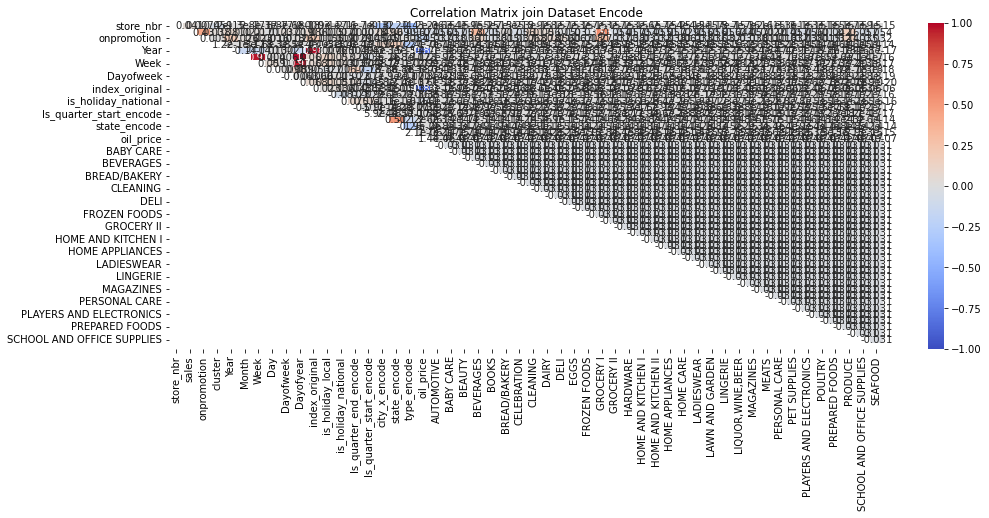

In [10]:
#Display the correlation matrix.
def matTriangleHeatmap(df,title):
    plt.figure(figsize=(16,6))
    matCorr = df.corr()
    maskTri = np.tril(np.ones_like(matCorr, dtype = bool))
    heatmapTri = sns.heatmap(matCorr, mask = maskTri, vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
    heatmapTri.set_title(title)

corr_mat_join_encode = matTriangleHeatmap(train_join_df_encode, 'Correlation Matrix join Dataset Encode')

In [11]:
#Show if there are nulls in the data.
train_join_df_encode.isnull().sum()

date                          0
store_nbr                     0
sales                         0
onpromotion                   0
cluster                       0
Year                          0
Month                         0
Week                          0
Day                           0
Dayofweek                     0
Dayofyear                     0
index_original                0
is_holiday_local              0
is_holiday_national           0
Is_quarter_end_encode         0
Is_quarter_start_encode       0
city_x_encode                 0
state_encode                  0
type_encode                   0
oil_price                     0
AUTOMOTIVE                    0
BABY CARE                     0
BEAUTY                        0
BEVERAGES                     0
BOOKS                         0
BREAD/BAKERY                  0
CELEBRATION                   0
CLEANING                      0
DAIRY                         0
DELI                          0
EGGS                          0
FROZEN F

In [12]:
#load again the data.
train_dataset_clean = pd.read_csv('./data/train_join_df_encoded.csv')
train_dataset_clean.drop('date', axis=1, inplace=True)

In [13]:
#Train split.
train_features, test_features, train_labels, test_labels = train_test_split(train_dataset_clean.drop('sales', axis=1), 
                                                            train_dataset_clean['sales'],train_size=0.8, random_state=43)
print(train_features.shape)
print(train_labels.shape)
#Unir al test de kaggle lo que se hizo en este modelo.
train_features

(2430648, 51)
(2430648,)


,store_nbr,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,index_original,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
223050,4,0,9,2016,10,42,20,3,294,2469190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2004119,36,0,10,2015,1,2,9,4,9,1312529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215903,4,0,9,2015,12,49,2,2,336,1895382,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
444634,8,0,8,2016,8,33,15,0,228,2352203,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2000654,36,1,10,2014,11,46,15,5,319,1216299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525776,28,33,10,2017,2,5,2,3,33,2654061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1439802,26,0,10,2015,2,8,16,0,47,1379881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2484501,45,0,11,2013,11,45,10,6,314,559058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1613617,29,0,10,2014,11,46,13,3,317,1212475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Display the metrics of the regressions made.
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', np.around(explained_variance,4))    
    print('r2: ', np.around(r2,4))
    print('root_mean_squared_log_error: ',np.around(np.sqrt(mean_squared_log_error),4))

In [15]:
#Join the models to use.
model_name = ['LR','AB', 'RF',]
model_run = [LinearRegression(n_jobs = -1), AdaBoostRegressor(n_estimators = 20, random_state = 43),
             RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 43)]
models = []
for name, model in zip(model_name,model_run):
    models.append((name,model))

models

[('LR', LinearRegression(n_jobs=-1)),
 ('AB', AdaBoostRegressor(n_estimators=20, random_state=43)),
 ('RF', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=43))]

In [16]:
#Fit and evaluate the models.
def evaluate_models(train_features,train_labels,test_features,test_labels,models,option='finalmode'):
    for name, model in models:        

        model.fit(train_features,train_labels)
        
        results = model.score(train_features,train_labels)
        
        #Results for test model and saving the model
        print("Results for {} on {}".format(name,option))
        print("Training score {}{} with score: {}".format(name,option,results))
        y_pred = pd.Series(model.predict(test_features), index=test_features.index).clip(0.0)
        print('Test scores')
        regression_results(y_pred, test_labels)
        
        #saving the model
        dump(model,"{}{}.joblib".format(name,option))

In [17]:
#Call the function to be used.
evaluate_models(train_features,train_labels,test_features,test_labels,models)

Results for LR on finalmode
Training score LRfinalmode with score: 0.5534060823991241
Test scores
explained_variance:  0.1198
r2:  0.1182
root_mean_squared_log_error:  2.5161
Results for AB on finalmode
Training score ABfinalmode with score: 0.453781589482221
Test scores
explained_variance:  0.4211
r2:  0.3835
root_mean_squared_log_error:  3.8365
Results for RF on finalmode
Training score RFfinalmode with score: 0.9921924856969193
Test scores
explained_variance:  0.9243
r2:  0.9243
root_mean_squared_log_error:  0.4513
